In [1]:
from scipy.io import loadmat
from scipy.signal import decimate
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from matplotlib import colormaps
import os
import numpy as np 
import warnings
import pandas as pd
import copy
warnings.filterwarnings("ignore")

from sklearn.svm import  SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, train_test_split

from tensorflow import keras, one_hot

Motor imagery signal segmentation:

In [4]:
def MIEEG_segmentation(EEG, marker, Fs, time_window):
    label = []
    instances = []
    if Fs==1000:
        EEG = decimate(EEG.T,5)
        legend =[]
        for i in range(0,len(marker),5):
            legend.append(marker[i])
        legend = np.array(legend)
        signal_length = int(time_window * 200)
        for i in range(1, 6):
            y = 1 * (legend == i)
            for j in range(len(y) - 1):
                if y[j] == 0 and y[j + 1] == 1:
                    sample = EEG[:, j + 1:j + 1 + signal_length]
                    instances.append(sample)
                    label.append(i)
    if Fs==200:
        EEG = EEG.T
        legend = marker.T
        signal_length = int(time_window * 200)
        for i in range(1, 6):
            y = 1 * (legend == i)
            y = y[0]
            for j in range(len(y) - 1):
                if y[j] == 0 and y[j + 1] == 1:
                    sample = EEG[:, j + 1:j + 1 + signal_length]
                    instances.append(sample)
                    label.append(i)
    return instances, np.array(label)

In [5]:
# bar label
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

FFT feature extraction functions:

In [6]:
# FFT coefficient within specific frequency range
def fft_coefficinet(signal, Fs, high_cut, low_cut):
    X = signal
    T = 1/Fs
    L = len(X)
    Y = fft(X)/L
    t = np.linspace(0, 0+(L*T), L)
    xf = fftfreq(len(t), T)[:L//2]
    freq_range = np.multiply(low_cut<=xf, xf<=high_cut)*1
    idx = np.where(freq_range == 1)[0]
    coeff = Y[idx]
    return coeff

# FFt feature extraction
def fft_feature_extraction(instances, Fs, frequency_range = [0, 5]):
    high_cut = frequency_range[1]
    low_cut = frequency_range[0]
    feature_matrix = []
    for instance in instances:
        instance_matrix = []
        for signal in instance:
            coeff = fft_coefficinet(signal, Fs, high_cut, low_cut)
            imag = np.imag(coeff)
            real = np.real(coeff)
            final_coef  = np.concatenate((real, imag[imag!=0]))
            instance_matrix.append(final_coef)
        feature_matrix.append(np.array(instance_matrix))
    return feature_matrix


def fft_derivative_feature_extraction(instances, Fs, frequency_range = [0, 5]):
    high_cut = frequency_range[1]
    low_cut = frequency_range[0]
    feature_matrix = []
    for instance in instances:
        instance_matrix = []
        for signal in instance:
            coeff = fft_coefficinet(signal, Fs, high_cut, low_cut)
            imag = np.imag(coeff)
            imag = imag[imag!=0]
            imag_D = imag[1:]-imag[:-1]
            real = np.real(coeff)
            real_D = real[1:]-real[:-1]
            final_coef  = np.concatenate((real, imag, real_D, imag_D))
            instance_matrix.append(final_coef)
        feature_matrix.append(np.array(instance_matrix))
    return feature_matrix

SVM classifier

In [7]:
def SVM_classifier(feature, Label, cv=3, kernel='linear', scale=True):
    SVM_clf = SVC(kernel=kernel)
    train_acc =[]
    test_acc = []
    scaler = StandardScaler()
    for k in range(cv):
        # train test split
        split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
        for train_index, test_index in split.split(feature,Label):
            X_train = feature[train_index, :]
            X_test = feature[test_index, :]
            y_train = Label[train_index]
            y_test = Label[test_index]
        if scale:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # SVM with linear kernel
        SVM_clf.fit(X_train,y_train)
        train_acc.append(SVM_clf.score(X_train, y_train))
        test_acc.append(SVM_clf.score(X_test, y_test))
    mean_train_acc = np.mean(train_acc)
    mean_test_acc = np.mean(test_acc)
    return mean_train_acc, mean_test_acc

LDA classifier:

In [8]:
def LDA_classifier(feature, Label, cv=3, scale=True):
    LDA_clf = LinearDiscriminantAnalysis()
    train_acc =[]
    test_acc = []
    scaler = StandardScaler()
    for k in range(cv):
        # train test split
        split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
        for train_index, test_index in split.split(feature,Label):
            X_train = feature[train_index, :]
            X_test = feature[test_index, :]
            y_train = Label[train_index]
            y_test = Label[test_index]
        if scale:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # SVM with linear kernel
        LDA_clf.fit(X_train,y_train)
        train_acc.append(LDA_clf.score(X_train, y_train))
        test_acc.append(LDA_clf.score(X_test, y_test))
    mean_train_acc = np.mean(train_acc)
    mean_test_acc = np.mean(test_acc)
    return mean_train_acc, mean_test_acc

feature Ranking:

In [9]:

def feature_ranking(features, label, used_electrodes, feature_ranking):
    X = []
    electrodes = feature_ranking[:used_electrodes]
    for faeture in features:
        X.append(faeture[electrodes,:].ravel())
    X = np.array(X)
    scale = MinMaxScaler()
    X_scaled = scale.fit_transform(X)
    f_score=chi2(X_scaled,label)
    feature_Pvalue = f_score[1]  # p values
    sorted_idx = np.argsort(feature_Pvalue)
    feature_Pvalue = feature_Pvalue[sorted_idx]
    return sorted_idx, feature_Pvalue, X

In [10]:
def feature_electrode_minimization(instances, label, Fs, used_electrodes, electrode_ranking, frequency_range = [0, 5],derevitive = True):
    # reduce the n umber of electrode to top electrodes
    Electrode = electrode_ranking[:used_electrodes]
    new_instances = []
    for instance in instances:
        new_instances.append(instance[Electrode,:])
    # feature extraction
    if derevitive:
        features = fft_derivative_feature_extraction(instances, Fs, frequency_range)
    else:
        features = fft_feature_extraction(instances, Fs, frequency_range)
    # feature ranking
    X = []
    for faeture in features:
        X.append(faeture.ravel())
    X = np.array(X)
    scale = MinMaxScaler()
    X_scaled = scale.fit_transform(X)
    f_score=chi2(X_scaled,label)
    feature_Pvalue = f_score[1]
    f_score=chi2(X_scaled,label)
    feature_Pvalue = f_score[1]  # p values
    sorted_X = X[:,np.argsort(feature_Pvalue)]
    return sorted_X

Sequential forward selection (SFS) algorithm for ranking EEG electrodes:

over all electrode ranking

In [ ]:
all_session_acc = np.zeros((21,16))
all_session_elec = np.zeros((21,16))

path = os.path.join(os.getcwd(), "dataset")
dataset_list = os.listdir(path)
for i, session in enumerate(dataset_list):
    print(f"{i+1} file out of {len(dataset_list)}")
    sample_1 = os.path.join(path,session)
    data = loadmat(sample_1)
    Fs = int(data['o']["sampFreq"][0, 0][0])
    marker = data["o"]["marker"][0, 0]
    EEG = data["o"]["data"][0, 0]
    EEG = np.delete(EEG, 21, 1)
    time_window = 0.85       # duration of motor imagery EEG signal (second)
    instances, label = MIEEG_segmentation(EEG, marker, Fs, time_window)
    feature_matrix = fft_feature_extraction(instances, 200, frequency_range = [0, 5])
    electrode_ranked = []
    channels = np.arange(21)
    for j in range(21):
        # remained electrode 
        acc_list = []
        remained_electrode = np.delete(channels, electrode_ranked)
        for k in remained_electrode:
            stage2_elec = copy.deepcopy(electrode_ranked)
            stage2_elec.append(k)
            feature = []
            for sample in feature_matrix:
                feature.append(sample[stage2_elec,:].ravel())
            feature = np.array(feature)
            clf = SVC(kernel='linear', C=1, random_state=42)
            mean_cv_acc, std_test_acc = K_foldCV_classifier(clf, feature, label, cv=3)
            acc_list.append(mean_cv_acc*100)
        acc_list = np.array(acc_list)
        electrode_ranked.append(remained_electrode[acc_list.argmax()])
        all_session_acc[j,i] = np.max(acc_list)
    all_session_elec[:,i]=np.array(electrode_ranked)

df1 = pd.DataFrame(all_session_acc)
df1.to_csv("session_acc.csv")
df2 = pd.DataFrame(all_session_elec)
df2.to_csv("session_elec.csv")

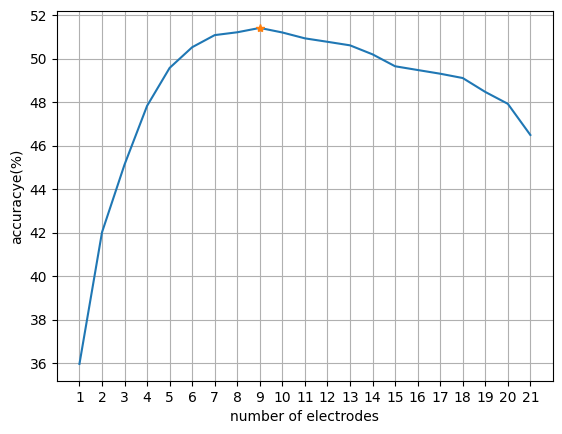

Highest accuracy attained using 9 top electrodes
accuracy = 51.43


In [91]:
accuracy_based_electttods = pd.read_csv("session_acc.csv", index_col=False).iloc[:,1:]
mean_acc = accuracy_based_electttods.mean(axis=1)
plt.plot(np.arange(1,22), mean_acc)

max_idx_acc = accuracy_based_electttods.mean(axis=1).idxmax() + 1
max_acc = accuracy_based_electttods.mean(axis=1).max()
plt.plot(max_idx_acc, max_acc , '*')
plt.xticks(np.arange(1,22))
plt.xlabel("number of electrodes")
plt.ylabel("accuracye(%)")
plt.grid(True)
plt.show()

print(f"Highest accuracy attained using {max_idx_acc} top electrodes")
print(f"accuracy = {np.round(max_acc,2)}")

In [92]:
# channels name in recording order
all_session_elec = pd.read_csv("session_elec.csv").iloc[:,1:].values

chName = data["o"]["chnames"]
ch_name = []
for i in range(21):
    ch_name.append(chName[0][0][i][0][0])

a, b = all_session_elec.shape
electrode_matrix = np.zeros((a,b))
electrode_rank_df = pd.DataFrame(electrode_matrix)
for i in range(a):
    for j in range(b):
        electrode_rank_df.iloc[i,j] = ch_name[int(all_session_elec[i,j])]


order = {}
for ch in ch_name:
    rows, cols = np.where(electrode_rank_df==ch)
    order[ch] = np.mean(rows)

sorted_order = sorted(order.items(), key=lambda x:x[1])
print("electrode order:")
for i in sorted_order:
    print(f"      {i[0]}")
ch_name = np.array(ch_name)


electrode_order =[]
for i in range(21):
    electrode_order.append(np.where(ch_name==sorted_order[i][0])[0][0])
np.save("electrode_order", electrode_order)

electrode order:
      P4
      P3
      T5
      O1
      T6
      C4
      O2
      F7
      C3
      Pz
      T4
      Fp1
      F3
      A1
      F8
      Cz
      T3
      A2
      F4
      Fp2
      Fz


feature ranking example:

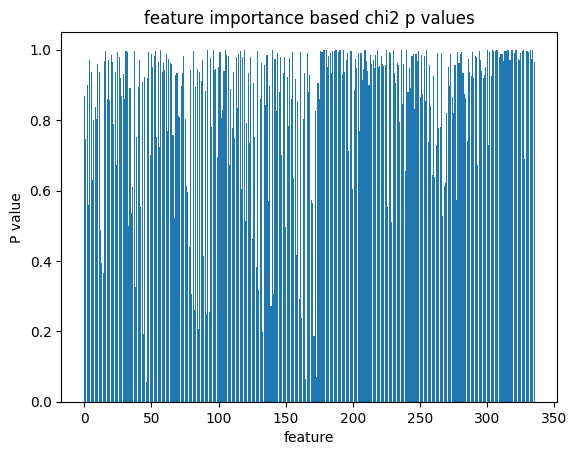

In [93]:
sample_1 = os.path.join(path,dataset_list[1])
data = loadmat(sample_1)
Fs = int(data['o']["sampFreq"][0, 0][0])
marker = data["o"]["marker"][0, 0]
EEG = data["o"]["data"][0, 0]
EEG = data["o"]["data"][0, 0]
EEG = np.delete(EEG, 21, 1)
time_window = .85
instances, label = MIEEG_segmentation(EEG, marker, Fs, time_window)
feature_matrix = fft_derivative_feature_extraction(instances, Fs, frequency_range = [0, 5])

with open('electrode_order.npy','rb') as f:
    order = np.load(f)

used_elctrode = 21
# to do : show in matmatrix
feature_rank, feature_Pvalue, X = feature_ranking(feature_matrix, label, used_elctrode, order)
plt.bar(x=feature_rank,height=feature_Pvalue )
plt.xlabel("feature")
plt.ylabel("P value")
plt.title("feature importance based chi2 p values")
plt.show()

effect of normalization of accuracy:

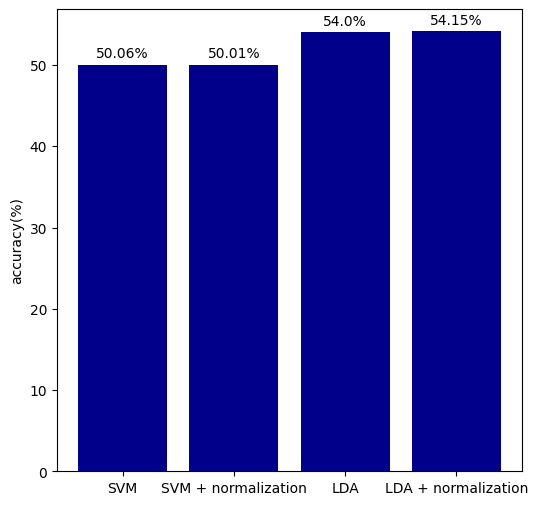

In [101]:
normaliation_acc = np.zeros((4,16))
with open('electrode_order.npy','rb') as f:
    order = np.load(f)


path = os.path.join(os.getcwd(), "dataset")
dataset_list = os.listdir(path)
for i, session in enumerate(dataset_list):
    sample_1 = os.path.join(path,session)
    data = loadmat(sample_1)
    Fs = int(data['o']["sampFreq"][0, 0][0])
    marker = data["o"]["marker"][0, 0]
    EEG = data["o"]["data"][0, 0]
    EEG = np.delete(EEG, 21, 1)
    time_window = 0.85       # duration of motor imagery EEG signal (second)
    instances, label = MIEEG_segmentation(EEG, marker, Fs, time_window)
    used_elctrode= 21
    feature_matrix = fft_derivative_feature_extraction(instances, 200, frequency_range = [0, 5])
    feature_rank, feature_Pvalue, X = feature_ranking(feature_matrix, label, used_elctrode, order)
    X = X[:,feature_rank]
    top_189 = X[:,:189]
    mean_train, normaliation_acc[0,i] = SVM_classifier(top_189, label, cv=10, kernel='linear', scale=False)
    mean_train, normaliation_acc[1,i] = SVM_classifier(top_189, label, cv=10, kernel='linear', scale=True)
    mean_train, normaliation_acc[2,i] = LDA_classifier(top_189, label, cv=10, scale=False)
    mean_train, normaliation_acc[3,i] = LDA_classifier(top_189, label, cv=10, scale=True)


height = np.round(normaliation_acc.mean(axis=1)*100, 2)
x = ["SVM", "SVM + normalization","LDA", "LDA + normalization"]
fig, ax = plt.subplots(figsize=(6,6))
bar = ax.bar(x, height,  color="darkblue")
autolabel(bar)
plt.ylabel("accuracy(%)")

normalization_result = pd.DataFrame({"accuracy":height}, index=x)
normalization_result.to_csv("normalization_result.csv")

faetures and elcectrode optimization for minimum calculation:

In [11]:
# generate  dataframe in order to evaluate the 
with open("electrode_order.npy", 'rb') as f:
    electrode_ranking = np.load(f)

path = os.path.join(os.getcwd(), "dataset")
dataset_list = os.listdir(path)

used_electrodes = 9
overall_result = {}
for i, session in enumerate(dataset_list):
    print(f"{i+1} file out of {len(dataset_list)}")
    sample_1 = os.path.join(path,session)
    data = loadmat(sample_1)
    Fs = int(data['o']["sampFreq"][0, 0][0])
    marker = data["o"]["marker"][0, 0]
    EEG = data["o"]["data"][0, 0]
    EEG = np.delete(EEG, 21, 1)
    time_window = 1       # duration of motor imagery EEG signal (second)
    instances, label = MIEEG_segmentation(EEG, marker, Fs, time_window)
    X = feature_electrode_minimization(instances, label, 200, used_electrodes, electrode_ranking, frequency_range = [0, 9], derevitive = True)

    MEAN_acc = []
    for j in range(5, min(X.shape[1], 190),5):
        reduces_X = X[:,:j]
        clf = LinearDiscriminantAnalysis()
        scores = cross_val_score(clf, reduces_X, label, cv=3)
        mean_acc = scores.mean(), 
        std_acc = scores.std()
        MEAN_acc.append(mean_acc)

    overall_result[str(i)] = MEAN_acc
 

1 file out of 16
2 file out of 16
3 file out of 16
4 file out of 16
5 file out of 16
6 file out of 16
7 file out of 16
8 file out of 16
9 file out of 16
10 file out of 16
11 file out of 16
12 file out of 16
13 file out of 16
14 file out of 16
15 file out of 16
16 file out of 16


In [12]:
final_result_df = pd.DataFrame()
final_result_df.index = np.arange(5,190,5)
for i in overall_result.keys():
    name = "session_" + str(int(i)+1)
    data = np.round(np.array(overall_result[i])*100,2)
    final_result_df[name] = data

best_result = pd.DataFrame()
best_result.index = final_result_df.columns
best_result["num_fetures"] = final_result_df.idxmax()
best_result["accuracy"] = final_result_df.max()
best_result

,num_fetures,accuracy
session_1,45,25.74
session_2,155,66.01
session_3,150,50.48
session_4,170,50.58
session_5,145,45.41
session_6,140,62.98
session_7,165,67.16
session_8,180,62.11
session_9,165,64.13
session_10,175,74.10


In [151]:
print(f"avrage accuracy of {np.round(best_result.mean()[1],2)} was achived with  {np.round(best_result.mean()[0],2)} numbers of features")

avrage accuracy of 54.17 was achived with  147.81 numbers of features


In [ ]:
mlp = keras.Sequential()
mlp.add(keras.layers.Input(shape =[150]))
mlp.add(keras.layers.Normalization(axis=-1, mean=0, variance=1, invert=False, ))
mlp.add(keras.layers.Dense(300, activation="relu"))
mlp.add(keras.layers.Dense(150, activation="relu"))
mlp.add(keras.layers.Dense(5, activation="softmax"))
mlp.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])

In [104]:
with open("electrode_order.npy", 'rb') as f:
    electrode_ranking = np.load(f)
path = os.path.join(os.getcwd(), "dataset")
dataset_list = os.listdir(path)

used_electrodes = 9
MLP_acc = []
for i, session in enumerate(dataset_list):
    Label = []
    X = []
    print(f"{i+1} file out of {len(dataset_list)}")
    sample_1 = os.path.join(path,session)
    data = loadmat(sample_1)
    Fs = int(data['o']["sampFreq"][0, 0][0])
    marker = data["o"]["marker"][0, 0]
    EEG = data["o"]["data"][0, 0]
    EEG = np.delete(EEG, 21, 1)
    time_window = 1       # duration of motor imagery EEG signal (second)
    instances, label = MIEEG_segmentation(EEG, marker, Fs, time_window)
    Electrode = electrode_ranking[:used_electrodes]
    new_instances = []
    for instance in instances:
        new_instances.append(instance[Electrode,:])
    # feature extraction
    features = fft_derivative_feature_extraction(new_instances, 200, [0,9])
    for faeture in features:
        X.append(faeture.ravel())
    for L in label:
        Label.append(L-1)
    X = np.array(X)
    y = np.array(Label)

    scale = MinMaxScaler()
    X_scaled = scale.fit_transform(X)
    f_score=chi2(X_scaled,y)
    feature_Pvalue = f_score[1]
    f_score=chi2(X_scaled,y)
    feature_Pvalue = f_score[1]  # p values
    sorted_idx = np.argsort(feature_Pvalue)
    feature_Pvalue = feature_Pvalue[sorted_idx]
    scale = MinMaxScaler()
    X_scaled = scale.fit_transform(X)
    f_score = chi2(X_scaled,y)
    feature_Pvalue = f_score[1]
    sorted_idx = np.argsort(feature_Pvalue)
    X = X[:,sorted_idx]
    X_reduce = X[:,:150]
    X_rest, X_test, y_rest , y_test = train_test_split(X_reduce, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=0.2)
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    X_val = scale.transform(X_val)
    mlp.fit(X_train, y_train, batch_size = 20, epochs=20,validation_data=(X_val, y_val), verbose=1)
    test_accuracy = mlp.evaluate(X_test, y_test)
    MLP_acc.append(np.round(test_accuracy[1]*100,2))
print(np.mean(MLP_acc))
    


1 file out of 16
Epoch 1/20
31/31 [==============================] - 1s 7ms/step - loss: 1.7046 - accuracy: 0.1913 - val_loss: 1.6555 - val_accuracy: 0.2384
Epoch 2/20
31/31 [==============================] - 0s 3ms/step - loss: 1.3185 - accuracy: 0.4859 - val_loss: 1.6749 - val_accuracy: 0.2715
Epoch 3/20
31/31 [==============================] - 0s 4ms/step - loss: 1.0810 - accuracy: 0.6589 - val_loss: 1.6978 - val_accuracy: 0.2914
Epoch 4/20
31/31 [==============================] - 0s 4ms/step - loss: 0.8964 - accuracy: 0.7671 - val_loss: 1.7963 - val_accuracy: 0.2583
Epoch 5/20
31/31 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.8336 - val_loss: 1.8429 - val_accuracy: 0.2318
Epoch 6/20
31/31 [==============================] - 0s 3ms/step - loss: 0.5397 - accuracy: 0.9235 - val_loss: 1.9766 - val_accuracy: 0.2450
Epoch 7/20
31/31 [==============================] - 0s 4ms/step - loss: 0.4460 - accuracy: 0.9301 - val_loss: 2.0335 - val_accuracy: 0.2185
Epo